In [3]:
import os
import numpy as np
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
# import neurokit2 as nk
import pandas as pd
from ecgdetectors import Detectors
import pyhrv.frequency_domain as fd
import pyhrv.time_domain as td
import biosppy

In [4]:
# Function that reads a csv file and outputs a data frame
def read_from_csv(file):
    data_frame = pd.read_csv(file, sep=",")
    return data_frame

In [5]:
# Function that writes a data frame to a csv file
def write_to_csv(df, file):
    df.to_csv(index=False)
    location = "C:/Users/riche/OneDrive/Documenten/Github/EPO4-C2/"
    path = location + file
    os.makedirs(location, exist_ok=True)  
    df.to_csv(path)

In [6]:
# filtering
def filter_signal(ecg, fs):
    nyq = 0.5*fs
    order=5

    # highpass filter
    high=0.5
    high= high/nyq
    b, a = butter(order, high, 'highpass')
    ecg_h = lfilter(b,a,ecg)

    # lowpass filter
    low = 70
    low= low/nyq
    b, a = butter(order, low, 'lowpass')
    ecg_hl = lfilter(b,a,ecg_h)

    # notch filter
    notch=50
    notch = notch/nyq
    b, a = iirnotch(notch, 30, fs)
    ecg_hln = lfilter(b,a,ecg_hl)

    t=np.arange(0,ecg.size*(1/fs),(1/fs))
    t=t[:ecg.size]

    # plt.figure(figsize=(12,4))
    # plt.plot(t,ecg,label="raw ECG")
    # plt.plot(t,ecg_hln, label="filtered ECG")
    # plt.xlabel('$Time (s)$') 
    # plt.ylabel('$ECG$') 
    # plt.legend()
    return ecg_hln

In [7]:
# detect R-peaks
def detect_rpeaks(fs, ecg_hln):
    detectors = Detectors(fs)

    r_peaks_pan = detectors.pan_tompkins_detector(ecg_hln)
    r_peaks_pan = np.asarray(r_peaks_pan)

    # plt.figure(figsize=(12,4))
    # plt.plot(ecg_hln)
    # plt.plot(r_peaks_pan,ecg_hln[r_peaks_pan], 'ro')
    return r_peaks_pan

# **Feature extraction**

In [8]:
from hrv import HRV   # to import the module

# Feature extraction
def get_features(r_peaks_pan, fs, df, index):
    features = []
    ecg_fft = fd.frequency_domain(rpeaks = r_peaks_pan, show = False)
    plt.close(ecg_fft["ar_plot"])
    plt.close(ecg_fft["lomb_plot"])
    plt.close(ecg_fft["fft_plot"])
    hrv_class = HRV(fs)
    # print(r_peaks_pan)
    #Number of pairs of succesive NNs that differ by more than 20ms(NN20)
    features.append(hrv_class.NN20(r_peaks_pan))
    # print(f"nn20:{feat_nn20}")
    #Number of pairs of succesive NNs that differ by more than 50ms(NN50)
    features.append(hrv_class.NN50(r_peaks_pan))
    # print(f"nn50:{feat_nn50}")
    #Root mean square of succesive differences(RMSSD)
    features.append(hrv_class.RMSSD(r_peaks_pan, normalise= True))
    # print(f"rmssd:{feat_rmssd}")
    #Heart-rate feature extraction in BPM(HR)
    features.append(np.mean(hrv_class.HR(r_peaks_pan)))
    # print(f"HR:{feat_hr}")
    #Standard deviation of succesive differences(SDSD)
    features.append(hrv_class.SDSD(r_peaks_pan))
    # print(f"SDSD:{feat_sdsd}")
    #The proportion of NN50 divided by total number of NNs(pNN50)
    features.append(hrv_class.pNN50(r_peaks_pan))
    # print(f"pNN50:{feat_pnn50}")
    #The proportion of NN20 divided by total number of NNs(pNN20)
    features.append(hrv_class.pNN20(r_peaks_pan))
    # print(f"pNN20:{feat_pnn20}")
    features.extend([ecg_fft['fft_peak'][0], ecg_fft['fft_peak'][1], ecg_fft['fft_peak'][2], ecg_fft['fft_norm'][0],
                     ecg_fft['fft_norm'][1], ecg_fft['fft_ratio'], ecg_fft['fft_total']])
    #The
    
    df.loc[index] = features
    return df

In [9]:
# set up an empty features file
df_features = pd.DataFrame(None, columns= ['feat_nn20', 'feat_nn50', 'feat_rmssd', 'feat_nnhr', 
                                     'feat_sdsd', 'feat_pnn50', 'feat_pnn20', 'peak vlf', 'peak lf','peak hf', 'norm power lf', 
                                     'norm power hf', 'power ratio', 'total power'])
#print(df_features)
write_to_csv(df_features, "out_features.csv")


In [10]:
# get features from all signals and write to a csv file

fs = 700
y = []
for label in range(1,5):
    file = "out_" + str(label) + ".csv"

    df = read_from_csv(file)

    for subject in df:
        if subject != 'Unnamed: 0':
            if label == 3 or label == 4:
                y.append(1)
            else:
                y.append(label)
            ecg = df[subject]
            filtered_ecg = filter_signal(ecg, fs)
            r_peaks_pan = detect_rpeaks(fs, filtered_ecg)
            df_features = get_features(r_peaks_pan, fs, df_features, subject+str(label))

write_to_csv(df_features, "out_features.csv")

In [11]:
df_features.head()
df_features.shape

(180, 14)

# **PCA**

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [13]:
df_features.keys()

Index(['feat_nn20', 'feat_nn50', 'feat_rmssd', 'feat_nnhr', 'feat_sdsd',
       'feat_pnn50', 'feat_pnn20', 'peak vlf', 'peak lf', 'peak hf',
       'norm power lf', 'norm power hf', 'power ratio', 'total power'],
      dtype='object')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

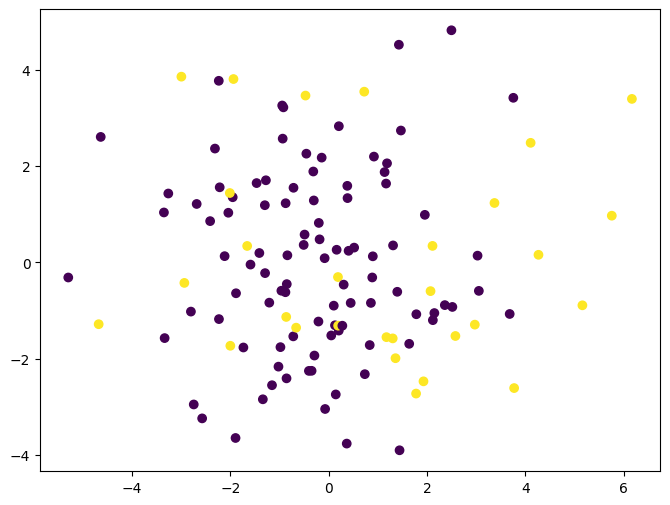

In [15]:
pca = PCA(n_components=4) 
pca = pca.fit(X_train)

X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)

In [16]:
model = LogisticRegression()
model.fit(X_train_pca, y_train)
print(model.score(X_test_pca, y_test))

0.7777777777777778


In [17]:
features = []
hrv_class = HRV(fs)
# print(r_peaks_pan)
#Number of pairs of succesive NNs that differ by more than 20ms(NN20)
features.append(hrv_class.NN20(r_peaks_pan))
# print(f"nn20:{feat_nn20}")
#Number of pairs of succesive NNs that differ by more than 50ms(NN50)
features.append(hrv_class.NN50(r_peaks_pan))
# print(f"nn50:{feat_nn50}")
#Root mean square of succesive differences(RMSSD)
features.append(hrv_class.RMSSD(r_peaks_pan, normalise= True))
# print(f"rmssd:{feat_rmssd}")
#Heart-rate feature extraction in BPM(HR)
features.append(np.mean(hrv_class.HR(r_peaks_pan)))
# print(f"HR:{feat_hr}")
#Standard deviation of succesive differences(SDSD)
features.append(hrv_class.SDSD(r_peaks_pan))
# print(f"SDSD:{feat_sdsd}")
#The proportion of NN50 divided by total number of NNs(pNN50)
features.append(hrv_class.pNN50(r_peaks_pan))
# print(f"pNN50:{feat_pnn50}")
#The proportion of NN20 divided by total number of NNs(pNN20)
features.append(hrv_class.pNN20(r_peaks_pan))
print(features)

[6, 6, 0.27781255832386553, 61.66615365970662, 273.3890080908489, 0.6666666666666666, 0.6666666666666666]


[ 690 1524 2326 3128 3907 4630 5247 5819 6687]
[ 249  662 1529 2331 3133 3938 4660 5277 5849 6719]


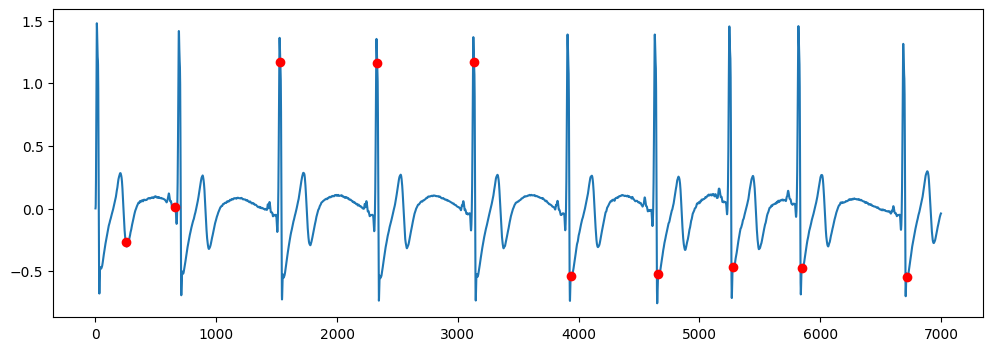

In [18]:
ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=700)

plt.figure(figsize=(12,4))
plt.plot(filtered_ecg)
plt.plot(r_peaks_pan,filtered_ecg[r_peaks_pan], 'ro')


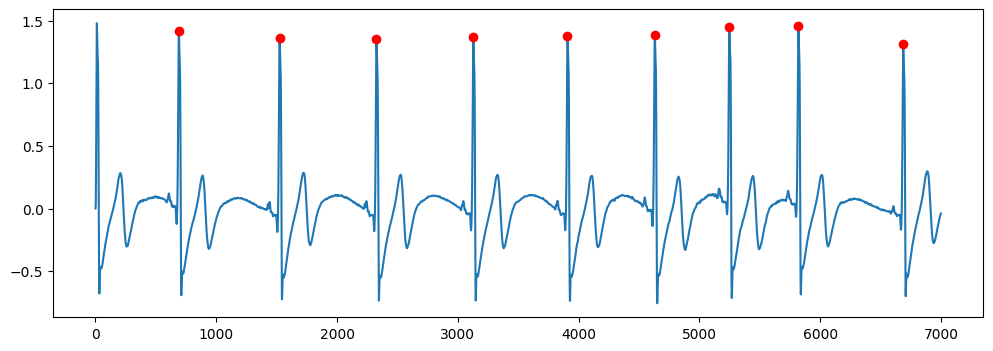

In [19]:
plt.figure(figsize=(12,4))
r_peaks = ecg_td['rpeaks']
plt.plot(filtered_ecg)
plt.plot(r_peaks,filtered_ecg[r_peaks], 'ro')


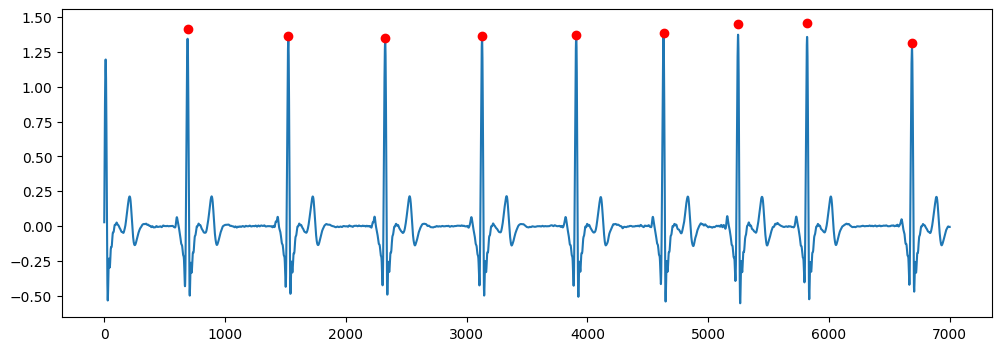

In [29]:
t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(ecg, sampling_rate=700, show = False, interactive=False)[:3]

plt.figure(figsize=(12,4))
plt.plot(filtered_signal)
plt.plot(rpeaks,filtered_ecg[rpeaks], 'ro')

In [34]:
hrv_class = HRV(fs)
print(td.hr_parameters(rpeaks = rpeaks))
print(hrv_class.HR(rpeaks))
print(np.mean(hrv_class.HR(rpeaks)))
print(td.hr_parameters(rpeaks = r_peaks))
print(hrv_class.HR(r_peaks))
print(td.hr_parameters(rpeaks = r_peaks_pan))
print(hrv_class.HR(r_peaks_pan))

print(td.nn20(rpeaks = rpeaks))
print(hrv_class.NN20(rpeaks))
print(hrv_class.pNN20(rpeaks))
print(td.nn50(rpeaks = rpeaks))
print(hrv_class.NN50(rpeaks))
print(hrv_class.pNN50(rpeaks))

print(td.rmssd(rpeaks=rpeaks))
print(hrv_class.RMSSD(rpeaks))

print(td.sdnn(rpeaks=rpeaks))
print(hrv_class.SDNN(rpeaks))




ReturnTuple(hr_mean=81.60525216968895, hr_min=69.12442396313364, hr_max=104.8951048951049, hr_std=12.824866019865137)
[50.35971223 52.36907731 52.36907731 53.91527599 58.09128631 68.0713128
 73.42657343 48.38709677]
57.12367651878226
ReturnTuple(hr_mean=81.60525216968895, hr_min=69.12442396313364, hr_max=104.8951048951049, hr_std=12.824866019865137)
[50.35971223 52.36907731 52.36907731 53.91527599 58.09128631 68.0713128
 73.42657343 48.38709677]
ReturnTuple(hr_mean=88.09450522815233, hr_min=68.96551724137932, hr_max=145.27845036319613, hr_std=24.80008971793943)
[101.69491525  48.44290657  52.36907731  52.36907731  52.17391304
  58.17174515  68.0713128   73.42657343  48.27586207]
ReturnTuple(nn20=6, pnn20=85.71428571428571)
6
0.75
ReturnTuple(nn50=3, pnn50=42.857142857142854)
4
0.5
ReturnTuple(rmssd=122.80414139131115)
175.43448770187274
ReturnTuple(sdnn=105.10530433807801)
140.4528708448901
